In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]

Populating the interactive namespace from numpy and matplotlib


/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [38]:
performance_df = pd.read_csv("../../data/greedy_algos_performance.csv")
tile_picked_df = pd.read_csv("../../data/all_tile_plus_greedy_algo_info.csv")
prob_df = pd.read_csv("../../data/all_tile_plus_probability_info.csv")
tile_info =pd.read_csv("../../data/all_pixel_tile_info.csv",index_col=0)
obj_info = pd.read_csv("../../data/all_object_info.csv",index_col=0)
approved_obj_info = pd.read_csv("../../data/approved_object_tbl.csv",index_col=0)

We want to find objects whose gt_aware is high, but the other algos is not doing well. 

In [11]:
['batch', 'objid','act_jacc (isoGT,i_by_o)']

['act_jacc (isoGT,i_by_o)']

In [76]:
performance_df['gt aware - isoGT']=performance_df['act_jacc (gt_aware,i_by_o)']-performance_df['act_jacc (isoGT,i_by_o)']

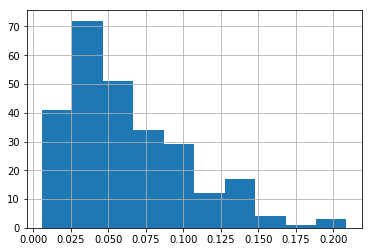

In [77]:
performance_df["gt aware - isoGT"].hist()

In [22]:
performance_df[performance_df["gt aware - isoGT"]>0.2]

,batch,objid,"est_jacc (gt_aware,i_by_o)","act_jacc (gt_aware,i_by_o)","est_jacc (adj_gt_aware,i_by_o)","act_jacc (adj_gt_aware,i_by_o)","est_jacc (mv,i_by_o)","act_jacc (mv,i_by_o)","est_jacc (adj_mv,i_by_o)","act_jacc (adj_mv,i_by_o)",...,"act_jacc (adj_mv_weighted,i_by_o)","est_jacc (GT,i_by_o)","act_jacc (GT,i_by_o)","est_jacc (adj_GT,i_by_o)","act_jacc (adj_GT,i_by_o)","est_jacc (isoGT,i_by_o)","act_jacc (isoGT,i_by_o)","est_jacc (adj_isoGT,i_by_o)","act_jacc (adj_isoGT,i_by_o)",gt aware - isoGT
58,15workers_rand0,15,0.948767,0.948767,0.948767,0.948767,1.0,0.806709,1.0,0.806709,...,0.647134,0.999994,0.735166,0.999994,0.735166,0.999102,0.740146,0.999102,0.740146,0.208621
190,20workers_rand0,15,0.960076,0.960076,0.960076,0.960076,1.0,0.809370,1.0,0.809370,...,0.676431,0.997790,0.741176,0.997790,0.741176,0.998032,0.752239,0.998032,0.752239,0.207837
234,30workers_rand0,15,0.980658,0.980658,0.980658,0.980658,1.0,0.832203,1.0,0.832203,...,0.681879,0.998392,0.751118,0.998392,0.751118,0.998040,0.773846,0.998040,0.773846,0.206811


This is the small area car object, it also had one worker circle the wrong object. The lower worker sample might not have contained that bad object. 

In [68]:
batch="15workers_rand0"
objid = 15

We want to look at tiles that were picked by the gt_aware but not by isoGT, in order to see where things went wrong 

In [69]:
tile_picked_selected_df = tile_picked_df[(tile_picked_df["batch"]==batch)&(tile_picked_df["objid"]==objid)]
tile_info_selected_df  = tile_info[(tile_info["batch"]==batch)&(tile_info["objid"]==objid)]
tile_info_selected_df["i_by_o"]=tile_info_selected_df["gt overlap area"]/tile_info_selected_df["tile area"]

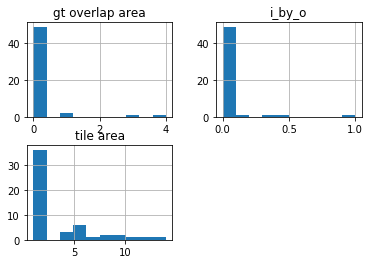

In [70]:
incorrect_tiles = tile_picked_selected_df[tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]!=tile_picked_selected_df["tile picked (isoGT,i_by_o)"]]["tile id"]
a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(incorrect_tiles)][["gt overlap area","tile area","i_by_o"]].hist()

split into false positive and true negatives 

52


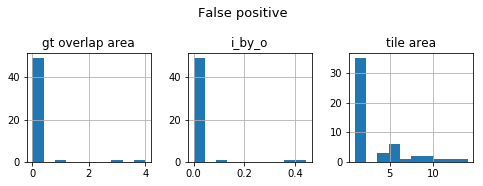

In [107]:
false_positive = tile_picked_selected_df[\
                (tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]=="no") & \
                (tile_picked_selected_df["tile picked (isoGT,i_by_o)"]=="yes")]["tile id"]
a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(false_positive)][["gt overlap area","tile area","i_by_o"]]\
        .hist(layout=(1,3),figsize=(8,2))
plt.suptitle("False positive",y=1.2,fontsize=13)
print len(false_positive)

1


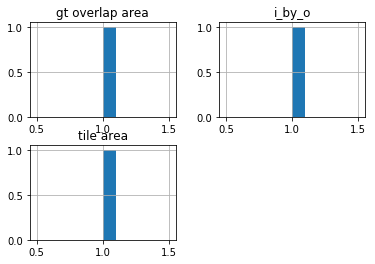

In [72]:
true_negative = tile_picked_selected_df[\
                (tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]=="yes") & \
                (tile_picked_selected_df["tile picked (isoGT,i_by_o)"]=="no")]["tile id"]
a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(true_negative)][["gt overlap area","tile area","i_by_o"]].hist()
print len(true_negative)

If you look at most of the mistakes for this object they are mostly false positives rather than true negatives.

In [78]:
performance_df[performance_df["gt aware - isoGT"]>0.15]

,batch,objid,"est_jacc (gt_aware,i_by_o)","act_jacc (gt_aware,i_by_o)","est_jacc (adj_gt_aware,i_by_o)","act_jacc (adj_gt_aware,i_by_o)","est_jacc (mv,i_by_o)","act_jacc (mv,i_by_o)","est_jacc (adj_mv,i_by_o)","act_jacc (adj_mv,i_by_o)",...,"act_jacc (adj_mv_weighted,i_by_o)","est_jacc (GT,i_by_o)","act_jacc (GT,i_by_o)","est_jacc (adj_GT,i_by_o)","act_jacc (adj_GT,i_by_o)","est_jacc (isoGT,i_by_o)","act_jacc (isoGT,i_by_o)","est_jacc (adj_isoGT,i_by_o)","act_jacc (adj_isoGT,i_by_o)",gt aware - isoGT
58,15workers_rand0,15,0.948767,0.948767,0.948767,0.948767,1.0,0.806709,1.0,0.806709,...,0.647134,0.999994,0.735166,0.999994,0.735166,0.999102,0.740146,0.999102,0.740146,0.208621
142,25workers_rand0,11,0.979817,0.979817,0.979817,0.979817,1.0,0.814773,1.0,0.814773,...,0.816575,0.994514,0.780390,0.994514,0.780390,0.985171,0.819921,0.985171,0.819921,0.159895
146,25workers_rand0,15,0.984436,0.984436,0.984436,0.984436,1.0,0.810147,1.0,0.810147,...,0.790476,0.995552,0.764706,0.995552,0.764706,0.995285,0.809756,0.995285,0.809756,0.174680
190,20workers_rand0,15,0.960076,0.960076,0.960076,0.960076,1.0,0.809370,1.0,0.809370,...,0.676431,0.997790,0.741176,0.997790,0.741176,0.998032,0.752239,0.998032,0.752239,0.207837
230,30workers_rand0,11,0.974638,0.974638,0.974638,0.974638,1.0,0.814467,1.0,0.814467,...,0.813596,0.995346,0.792596,0.995346,0.792596,0.991071,0.817930,0.991071,0.817930,0.156707
234,30workers_rand0,15,0.980658,0.980658,0.980658,0.980658,1.0,0.832203,1.0,0.832203,...,0.681879,0.998392,0.751118,0.998392,0.751118,0.998040,0.773846,0.998040,0.773846,0.206811
236,30workers_rand0,17,0.977768,0.977768,0.977768,0.977768,1.0,0.836804,1.0,0.836804,...,0.831895,0.999568,0.806626,0.999568,0.806626,0.996423,0.822616,0.996423,0.822616,0.155152


In [115]:
mistake_info = tile_info_selected_df[tile_info_selected_df["tile id"].isin(incorrect_tiles)][["gt overlap area","tile area","i_by_o"]]

In [152]:
objinfo_tbl = pd.merge(obj_info,approved_obj_info,left_on="objid",right_on="id")[['objid', u'GT area', u'GT num Points', u'is_hard',
       u'is_task_ambiguity', u'is_small_area', u'is_high_numPts', 'image_id', u'name']]

In [161]:
def debug_bad_objs(batch,objid):
    print '------------------------'
    print "Object info: \n", 
    print objinfo_tbl[objinfo_tbl["objid"]==objid][['name','GT area','is_hard','is_task_ambiguity', u'is_small_area', u'is_high_numPts']]
    print '------------------------'
    tile_picked_selected_df = tile_picked_df[(tile_picked_df["batch"]==batch)&(tile_picked_df["objid"]==objid)]
    print "Min tile areas:\n" , tile_picked_selected_df[["real_int_area","tile_area"]].min()
    print '------------------------'
    print "Max tile areas:\n" , tile_picked_selected_df[["real_int_area","tile_area"]].max()
    tile_info_selected_df  = tile_info[(tile_info["batch"]==batch)&(tile_info["objid"]==objid)]
    tile_info_selected_df["i_by_o"]=tile_info_selected_df["gt overlap area"]/tile_info_selected_df["tile area"]

    incorrect_tiles = tile_picked_selected_df[tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]!=tile_picked_selected_df["tile picked (isoGT,i_by_o)"]]["tile id"]
    a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(incorrect_tiles)][["gt overlap area","tile area","i_by_o"]]\
            .hist(layout=(1,3),figsize=(8,2))
    plt.suptitle("All mistakes",y=1.2,fontsize=13)

    false_positive = tile_picked_selected_df[\
                (tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]=="no") & \
                (tile_picked_selected_df["tile picked (isoGT,i_by_o)"]=="yes")]["tile id"]
    a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(false_positive)][["gt overlap area","tile area","i_by_o"]]\
            .hist(layout=(1,3),figsize=(8,2))
    plt.suptitle("False positive",y=1.2,fontsize=13)
    print "Number of false positives:", len(false_positive)
    
    true_negative = tile_picked_selected_df[\
                (tile_picked_selected_df["tile picked (gt_aware,i_by_o)"]=="yes") & \
                (tile_picked_selected_df["tile picked (isoGT,i_by_o)"]=="no")]["tile id"]
    a = tile_info_selected_df[tile_info_selected_df["tile id"].isin(true_negative)][["gt overlap area","tile area","i_by_o"]]\
            .hist(layout=(1,3),figsize=(8,2))
    plt.suptitle("True negatives",y=1.2,fontsize=13)
    print "Number of true negatives:",len(true_negative)
    

------------------------
Object info: 
     name  GT area  is_hard  is_task_ambiguity  is_small_area  is_high_numPts
10  spoon   1504.5     True              False          False            True
------------------------
Min tile areas:
real_int_area    0.0
tile_area        1.0
dtype: float64
------------------------
Max tile areas:
real_int_area       799.0
tile_area        305382.0
dtype: float64
Number of false positives: 122
Number of true negatives: 139


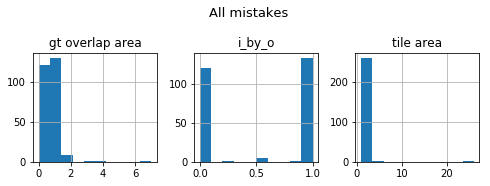

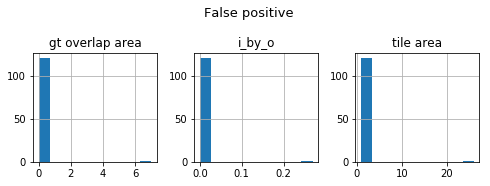

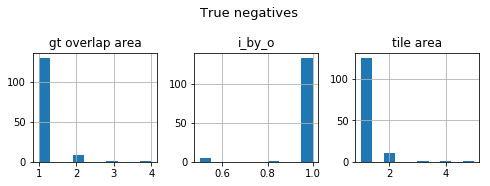

In [162]:
debug_bad_objs("25workers_rand0",11)

again most mistakes are on small tiles 

------------------------
Object info: 
   name  GT area  is_hard  is_task_ambiguity  is_small_area  is_high_numPts
14  car    460.5     True              False           True           False
------------------------
Min tile areas:
real_int_area    0.0
tile_area        1.0
dtype: float64
------------------------
Max tile areas:
real_int_area       268.0
tile_area        284079.0
dtype: float64
Number of false positives: 96
Number of true negatives: 2


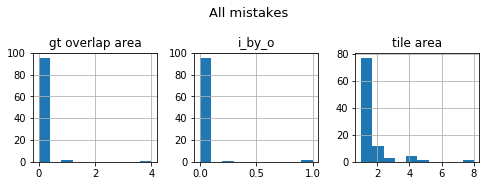

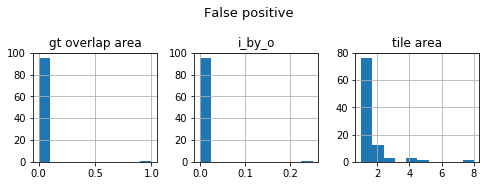

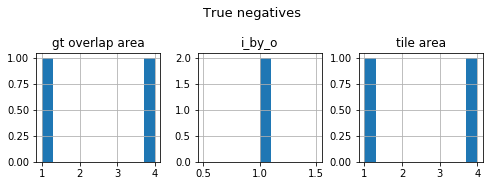

In [163]:
debug_bad_objs("30workers_rand0",15)

In [ ]:
debug_bad_objs("30workers_rand0",15)

------------------------------------------------------------------------------------